**Clustering task**  
Combine tweets from all 16 accounts and cluster the tweets with K-means clustering, using K = 16. Graph these clusters in two dimensions. You may choose to use principal components analysis (PCA) or another method of your choice to choose two dimensions for visualization.

In [1]:
# Set up Notebook

% matplotlib inline

import matplotlib.pyplot as plt
import re
import glob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import warnings
import collections
warnings.filterwarnings("ignore")

In [2]:
# Load file from working direction
files = glob.glob('./Health-News-Tweets/Health-Tweets/*')

Here, we save data as a dictionary, with twitter acounts' names and tweets content.

In [96]:
twitters = pd.DataFrame(columns = ['account', 'tweet'])
for i in range(len(files)):
    account_name = re.findall(r'(?<=\\).*(?=.txt)', files[i])
    try:
        with open (files[i], 'r', encoding='utf-8') as f:
            lines = f.readlines()
            f.close()
    except:
        with open (files[i], 'r', encoding='cp1252') as f:
            lines = f.readlines()
            f.close()
    for line in lines:
        try:
            tw = re.search(r'(?<=\|).*(?=http)', line)
            tw = re.sub('(.*)\|', '', tw[0]).strip()
            twitters.loc[-1] = [account_name[0],tw]
            twitters = twitters.reset_index(drop=True)
        except:
            tw = re.sub('(.*)\|', '', line).strip()
            twitters.loc[-1] = [account_name[0],tw]
            twitters = twitters.reset_index(drop=True)

Create a list of combined tweets from all 16 accounts.

In [73]:
tweets = list(twitters.tweet)

Build our own stop words list on top of the stopwords from nltk.corpus, because for most of tweets, "video" and "audio" are very common but not related to health at all.

In [74]:
stoplist = set(stopwords.words('english'))
stoplist.add('video:')
stoplist.add('audio:')

**Words to Vectors**  
We apply term frequency-inverse document frequency (tf-idf) vectorizer and then convert the tweets list into a tf-idf matrix.

In [112]:
# Define vectorizer parameters.
tfidf_vectorizer = TfidfVectorizer(analyzer='word',max_features=2000,
                                   stop_words=stoplist,ngram_range=(1))

In [78]:
# Fit vectorizer and transform the list
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)

**K-means Clustering**  
Initalize k-means with k = 16, and max iteration times = 300.

In [80]:
clustering_model = KMeans(n_clusters=16, max_iter=300, n_jobs=-1)

In [81]:
# Predict labels
labels = clustering_model.fit_predict(tfidf_matrix)

In [83]:
# Check the frequency of labels
labels_list = list(labels)
ctr = collections.Counter(labels_list)
print("Frequency of the elements in the List : ",ctr)

Frequency of the elements in the List :  Counter({1: 27728, 3: 5473, 12: 4118, 0: 3680, 5: 3531, 4: 2775, 14: 2412, 6: 2085, 7: 2068, 13: 2020, 2: 1871, 15: 1846, 9: 1194, 8: 967, 10: 959, 11: 600})


**Dimension deduction with PCA**  
We use principal components analysis (PCA) to choose two dimensions for visualization.

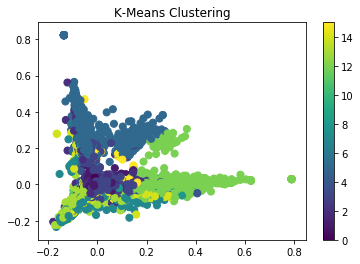

In [124]:
reduced_data = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())
reduced_df = pd.DataFrame(reduced_data)

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(reduced_df[0], reduced_df[1], c=labels, s=50)
ax.set_title('K-Means Clustering')
plt.colorbar(scatter)

**Question.1 Does each Twitter account form its own cluster?**  
To answer this question, we add new labels to the dataframe:

In [125]:
twitters['label'] = pd.Series(labels)
twitters.head()

,account,tweet,label
0,bbchealth,Breast cancer risk test devised,13
1,bbchealth,GP workload harming care - BMA poll,1
2,bbchealth,Short people's 'heart risk greater',1
3,bbchealth,New approach against HIV 'promising',4
4,bbchealth,Coalition 'undermined NHS' - doctors,9


Then, we aggreate data by account and label separately, to find with cluster of data can represent the certain account and which account support the label.

Noticed that the total tweets number per account is different, so we calculate the percentage of total account number for comparison. So did for labels.

In [191]:
account_count = twitters.groupby('account')['tweet'].count()
label_group = twitters.groupby(['label','account']).count().reset_index(['label','account'])
label_group['account_percentage'] = 0
for index, row in label_group.iterrows():
    label_group.loc[index, 'account_percentage'] = row['tweet'] / account_count[row['account']]


In [209]:
idx = label_group.groupby('label')['account_percentage'].transform(max) == label_group['account_percentage']
label_group[idx]

,label,account,tweet,account_percentage
5,0,everydayhealth,643,0.198518
27,1,nprhealth,2899,0.599338
41,2,latimeshealth,310,0.074323
62,3,wsjhealth,1518,0.474375
75,4,nytimeshealth,1374,0.220016
90,5,reuters_health,1207,0.255775
100,6,goodhealth,538,0.068404
117,7,msnhealthnews,570,0.178181
130,8,goodhealth,450,0.057216
139,9,gdnhealthcare,919,0.306640


According to the table above, the clusters are able to represent some twitter account. Tabke the label 2 as an example, it managed to represent about 60% nprhealth's tweets. However, for most of clusters, they did not make any sense here.

In [210]:
label_count = dict(ctr)
account_group = twitters.groupby(['account','label']).count().reset_index(['label','account'])
account_group['label_percentage'] = 0
for index, row in account_group.iterrows():
    account_group.loc[index, 'label_percentage'] = row['tweet'] / label_count[row['label']]

In [212]:
idx = account_group.groupby('account')['label_percentage'].transform(max) == account_group['label_percentage']
account_group[idx]

,account,label,tweet,label_percentage
13,KaiserHealthNews,15,420,0.227519
21,NBChealth,7,288,0.139265
39,bbchealth,10,785,0.818561
54,cbchealth,11,92,0.153333
73,cnnhealth,15,294,0.159263
74,everydayhealth,0,643,0.174728
90,foxnewshealth,2,137,0.073223
110,gdnhealthcare,9,919,0.769682
124,goodhealth,8,450,0.465357
133,latimeshealth,2,310,0.165687


On the other hand, in the table grouped by account, we calculate how many tweets are labeled by one single label. For instance, in label 10, 81.9% tweets are labeled as bbchealth, which is a considerable result. However, also, some of them failed to represent. 

***Why or why not is this the case?***  
We believe that for those who can be clustred fairly successfully, their tweets contain some unique words like location, slang, etc. More work need to be done, such as stemming, or analyzing the features of tfid-matrix.

**Optional bonus task**  
Change one of the parameters used in the clustering task. How do your results differ, and why?

In [ ]:
# Define vectorizer parameters.
tfidf_vectorizer = TfidfVectorizer(analyzer='word',max_features=2000,
                                   stop_words=stoplist,ngram_range=(1,2))

We define the ngram_range to 1-2 to catch some bigrams, but results did not differ a lot.